In [2]:
# Basic setting
import os
import pickle
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# [과제] 최적의 SVM 모델 찾기

---

## 본 과제의 목표는 다음과 같음

1. `rbf` 커널 함수를 사용한 SVM 모델을 정의할 수 있음
2. 학습과 평가 데이터셋을 나눌 수 있으며, 평가 데이터셋에 대한 분류 성능을 평가할 수 있음
3. `sklearn`에서 제공하는 하이퍼파라미터 서치 툴을 사용할 수 있음
4. SVM 모델 구현에 사용되는 하이퍼파라미터의 역할을 이해하고 분석할 수 있음

## [P.1] SVM 모델을 다양한 하이퍼파라미터로 학습하기

`rbf` 커널 함수를 사용한 SVM 모델을 정의할 때, 다양한 하이퍼파라미터 값을 설정해서 학습하며 성능 비교하기    
참고로, 이전 practice 파일에서처럼 학습 데이터셋이 아닌, 사이킷런 함수를 통해 만든 평가 데이터셋에 대해서 성능 평가하기    
또한 첫번째 피처인 'sepal length'와 'sepal width' 데이터만을 사용해서 모델 학습

In [3]:
# Make train and test dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

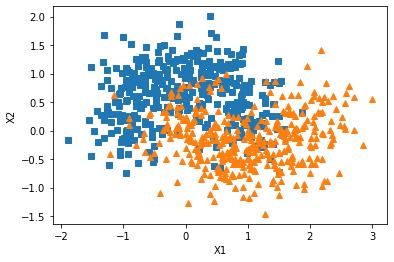

In [8]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "s")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "^")
    
    plt.xlabel("X1")
    plt.ylabel("X2")
    
    
plot_dataset(X_train, y_train)

In [9]:
# define model with pipeline
from sklearn.pipeline import Pipeline  # pipeline
from sklearn.preprocessing import StandardScaler   # scaler
from sklearn.svm import SVC   # svc

In [10]:
# 평가 데이터셋에 대한 성능 확인을 위해서 sklearn.metrics 안의 함수를 사용해주세요
from sklearn.metrics import accuracy_score

In [11]:
gamma1, gamma2 = 0.1, 1
C1, C2 = 0.1, 10

params = [(gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)]

svm_clfs = []
for g, C in params:
    svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=g, C=C))
        ])
    svm_clf.fit(X_train, y_train)
    svm_clfs.append(svm_clf)

In [14]:
def plot_predictions(clf):
    x0 = np.linspace(-3, 3, 100)
    x1 = np.linspace(-3, 3, 100)
    x0, x1 = np.meshgrid(x0, x1)
    X = np.c_[x0.ravel(), x1.ravel()]
    
    y_pred = clf.predict(X)
    y_pred = y_pred.reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, alpha=0.1)

[(0.1, 0.1)] Acc: 0.84
[(0.1, 10)] Acc: 0.86
[(1, 0.1)] Acc: 0.868
[(1, 10)] Acc: 0.856


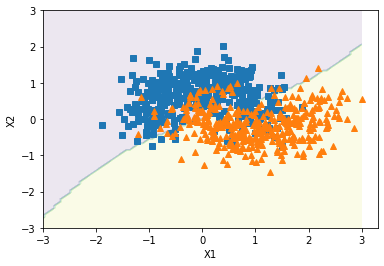

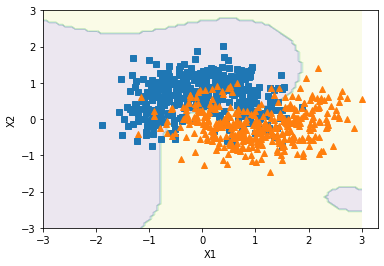

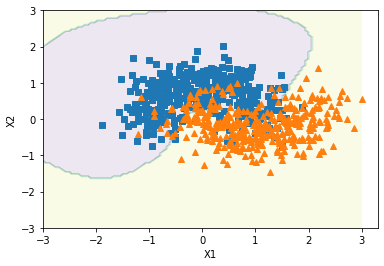

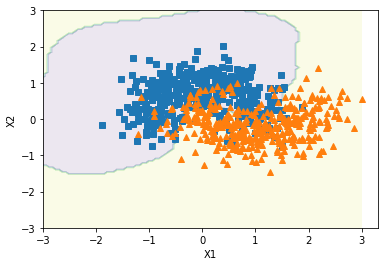

In [15]:
for i, svm_clf in enumerate(svm_clfs):
    plt.figure(figsize=(6, 4))
    
    plot_dataset(X_train, y_train)
    
    plot_predictions(svm_clf)
    
    y_pred = svm_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print('[%s] Acc: %s' % (params[i], acc))

## [P.2] GridSearchCV를 이용해 최적의 하이퍼파라미터 찾기

직접 하나부터 열까지 구현하는 것을 방지하기 위해 사이킷런에서는 유용한 툴을 제공해주고 있음    
`sklearn`의 [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 클래스를 이용해서 교차 검증을 구현해보기     
`make_moons` 데이터셋에 가장 적합한 하이퍼파라미터를 찾고, 평가 데이터에 대한 최고 성능 얻기

In [16]:
from sklearn.model_selection import GridSearchCV

svm_clf = SVC()
param_grid = {'kernel' : ["linear", "poly", "rbf"], "gamma" : [0.1, 1], "C" : [0.1, 10]}

grid_search_cv = GridSearchCV(svm_clf, param_grid)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 10], 'gamma': [0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']})

In [17]:
# get results of cross-validation
grid_search_cv.cv_results_

{'mean_fit_time': array([0.00311098, 0.00429697, 0.00659361, 0.0021914 , 0.0030242 ,
        0.00520773, 0.00463309, 0.00267339, 0.00493279, 0.00461054,
        0.00837412, 0.00584426]),
 'std_fit_time': array([1.56511932e-03, 6.52910748e-05, 1.28766217e-04, 4.06450467e-05,
        8.08213805e-05, 1.67463173e-04, 3.44411448e-04, 3.44291618e-05,
        1.28190786e-04, 3.53775607e-04, 4.16783680e-04, 3.40485959e-04]),
 'mean_score_time': array([0.00061178, 0.00097604, 0.00140653, 0.0005476 , 0.00064721,
        0.00107923, 0.00045786, 0.00062056, 0.00089273, 0.00045919,
        0.00053592, 0.00081635]),
 'std_score_time': array([2.42329939e-05, 1.51146097e-05, 2.89100986e-05, 9.29820232e-06,
        1.46456557e-05, 2.43058825e-05, 1.05988791e-05, 7.02489733e-06,
        2.40500894e-05, 1.11848557e-05, 1.17513032e-05, 2.27116692e-05]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False,

In [18]:
grid_search_cv.best_estimator_

SVC(C=10, gamma=1)

In [19]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.856

## [P.3] 하이퍼파라미터 서치 결과 분석

P.2에서 구현했던 내용을 바탕으로, 아래 질문에 대한 답변 작성

#### Q.1) 어떤 하이퍼파라미터와 값들을 후보군으로 설정했는지 서술
---

1. Kernel 함수 : 선형부터 비선형의 결정 경계를 만들어주는 하이퍼파라미터. 'linear', 'poly' 뿐만 아니라, 일반적으로 좋은 성능을 보여주는 'rbf' 커널을 후보군으로 사용함
2. `gamma`: 'poly'와 'rbf' 커널을 사용할 때, 커널의 coefficient를 결정하는 파라미터로, [0.1, 5]를 서치에 사용
3. `C`: 정규화 영향을 반비례하게 결정해주는 하이퍼파라미터로 [0.1, 1, 10]을 후보군으로 사용

#### Q.2) 해당 하이퍼파라미터의 역할을 분석하고, 왜 해당 결과값이 가장 좋은 성능을 보여줄 수 있었는지에 대해 자유롭게 작성
---

'rbf' 커널과 `C=10`, `gamma=1`일 때 가장 좋은 성능을 보여줌    
보다 큰 `gamma` 값과 'rbf' 커널이 선택된 것으로 보아, 선형보다는 비선형 모델일 때 더 알맞은 데이터 분포로 보임       
또한, `C`의 값이 크게 선택된 것을 통해 더 작은 정규화로 학습 데이터셋에 잘 피팅되었을 때, 평가 데이터셋 성능이 증가한다는 것을 알 수 있음